In [1]:
# PAIRWISE LEARNING
require(compiler)
require(MASS)
require(nnet)
setMKLthreads(16)
#setwd()

Loading required package: compiler
Loading required package: MASS
Loading required package: nnet


In [2]:
load('Haplotype_16Filtered.RData')
ls()

[1] "haplotype" "label"     "POS"

In [3]:
# JUST SOME FUNCTIONS
fsum<-function(x) {.Primitive('sum')(x)}
gc2<-function() {invisible(gc())}

In [4]:
# CHOOSE THE TWO TARGETED POPULATIONS
pop1<-'BFgam'
pop2<-'CMgam'
haplotype1<-haplotype[label==pop1,]
haplotype2<-haplotype[label==pop2,]
dim(haplotype1)
dim(haplotype2)
rm(haplotype); gc2(); 

[1]    184 117461

[1]    594 117461

In [5]:
# NEED TO CALCULATE WITHIN-POPULATION MAF
mode(haplotype1)<-'numeric'
mode(haplotype2)<-'numeric'
freq1<-apply(haplotype1, 2, fsum)/nrow(haplotype1)
maf1<-freq1
maf1[maf1>0.5]<-1-maf1[maf1>0.5]
freq2<-apply(haplotype2, 2, fsum)/nrow(haplotype2)
maf2<-freq2
maf2[maf2>0.5]<-1-maf2[maf2>0.5]

In [6]:
# SELECT THOSE LOCI WITH MAF>=5% AT BOTH POPULATIONS?
s<-maf1>=0.05 & maf2>=0.05
sum(s)
#plot(maf1, maf2)
haplotype1<-haplotype1[,s]
haplotype2<-haplotype2[,s]
freq1<-freq1[s]
freq2<-freq2[s]
POS<-POS[s]
dim(haplotype1)
dim(haplotype2)
length(POS)
rm(maf1); rm(maf2); rm(s); gc2()
# THERE ARE 99026

[1] 99026

[1]   184 99026

[1]   594 99026

[1] 99026

In [7]:
# I DON'T THINK I NEED ANOTHER ROUND OF LD PRUNNING AS IT HAS ALREADY BEEN DONE ON THE GLOBAL SCALE
# CALCULATE HUDSON'S FST (BHATIA ET AL.)



In [8]:
# CREATE GENOTYPE DATASETS AND COMBINE THE TWO POPULATIONS
odd<-seq(1, nrow(haplotype1), 2)
even<-seq(2, nrow(haplotype1), 2)
genotype1<-haplotype1[odd,]+haplotype2[even,]
rm(odd); rm(even);
odd<-seq(1, nrow(haplotype2), 2)
even<-seq(2, nrow(haplotype2), 2)
genotype2<-haplotype2[odd,]+haplotype2[even,]
rm(odd); rm(even);
dim(genotype1)
dim(genotype2)
genotype_both<-rbind(genotype1, genotype2)
label1<-rep(pop1, nrow(genotype1))
label2<-rep(pop2, nrow(genotype2))
label_both<-c(label1, label2)
col1<-rep(1, nrow(genotype1))
col2<-rep(2, nrow(genotype2))
col_both<-c(col1, col2)

[1]    92 99026

[1]   297 99026

   user  system elapsed 
   2.63    0.01    0.79 

   user  system elapsed 
   0.98    0.00    0.08 

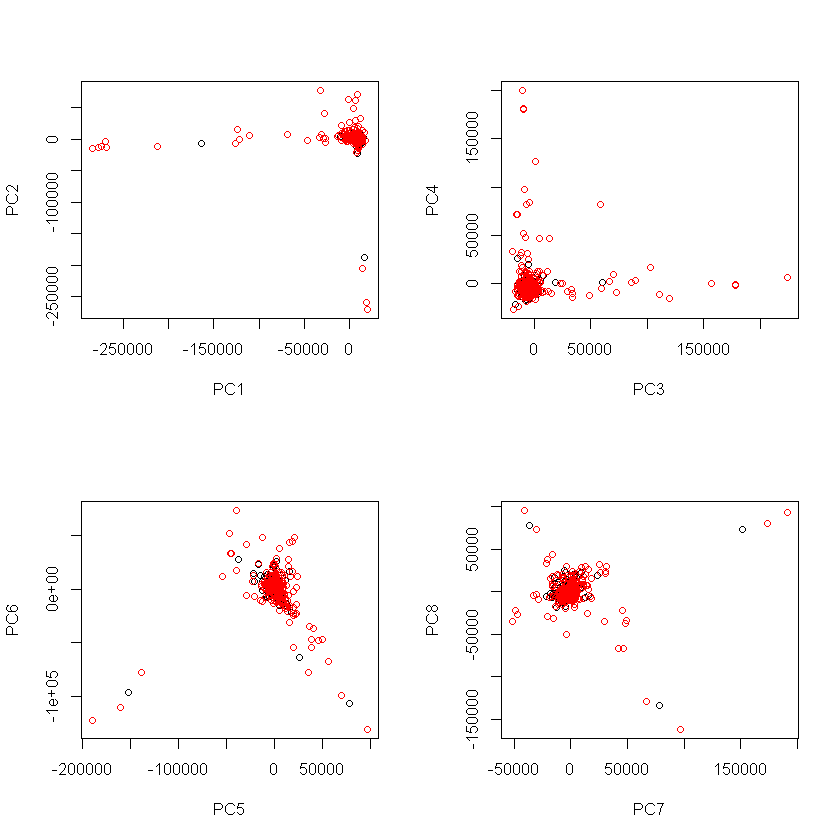

In [9]:
# PATTERSON NORMALISATION AND PCA
freq_both<-apply(genotype_both, 2, fsum)/(2*nrow(genotype_both))
freq_both2<-matrix(freq_both, nc=ncol(genotype_both), nr=nrow(genotype_both), byrow=T)
normal_genotype_both<-(genotype_both-2*freq_both2)/sqrt(freq_both2*(1-freq_both2))
system.time(x<-normal_genotype_both%*%t(normal_genotype_both))
system.time(e<-eigen(x))
PC1<-x%*%e$vector[,1]
PC2<-x%*%e$vector[,2]
PC3<-x%*%e$vector[,3]
PC4<-x%*%e$vector[,4]
PC5<-x%*%e$vector[,5]
PC6<-x%*%e$vector[,6]
PC7<-x%*%e$vector[,7]
PC8<-x%*%e$vector[,8]
par(mfrow=c(2,2))
plot(PC1, PC2, col=col_both)
plot(PC3, PC4, col=col_both)
plot(PC5, PC6, col=col_both)
plot(PC7, PC8, col=col_both)
# NO SIGNIFICANT SEPARATION FOR PC1-PC8

In [10]:
##########################################
# SUPERVISED LEARNING?
##########################################
# SPLIT INTO TRAINING AND TESTING SET. 80:20, STRATIFIED. 
s<-sample(nrow(genotype1), size=round(0.8*nrow(genotype1)))
train_genotype1<-genotype1[s,]
test_genotype1<-genotype1[-s,]
train_label1<-label1[s]
test_label1<-label1[-s]
train_col1<-col1[s]
test_col1<-col1[-s]
rm(s)
s<-sample(nrow(genotype2), size=round(0.8*nrow(genotype2)))
train_genotype2<-genotype2[s,]
test_genotype2<-genotype2[-s,]
train_label2<-label2[s]
test_label2<-label2[-s]
train_col2<-col2[s]
test_col2<-col2[-s]
rm(s)
# COMBINE
train_genotype<-rbind(train_genotype1, train_genotype2)
train_label<-c(train_label1, train_label2)
train_col<-c(train_col1, train_col2)
test_genotype<-rbind(test_genotype1, test_genotype2)
test_label<-c(test_label1, test_label2)
test_col<-c(test_col1, test_col2)

In [11]:
# CHECK DIMINSIONS
dim(train_genotype)
length(train_label)
length(train_col)
dim(test_genotype)
length(test_label)
length(test_col)

[1]   312 99026

[1] 312

[1] 312

[1]    77 99026

[1] 77

[1] 77

In [12]:
# REPEAT PATTERSON'S NORMALISATION BUT ONLY ON THE TRAINING SET
train_freq<-apply(train_genotype, 2, fsum)/(2*nrow(train_genotype))
train_freq2<-matrix(train_freq, nc=ncol(train_genotype), nr=nrow(train_genotype), byrow=T)
normal_train_genotype<-(train_genotype-2*train_freq2)/sqrt(train_freq2*(1-train_freq2))
rm(train_freq2); gc2(); 

In [13]:
# PCA VIA prccmp(). USE FIRST n=50 COMPONENTS
system.time(e<-prcomp(normal_train_genotype))
n<-50
train_feature<-normal_train_genotype%*%e$rotation[,1:n]
dim(train_feature)

   user  system elapsed 
  19.91    0.63    2.67 

[1] 312  50

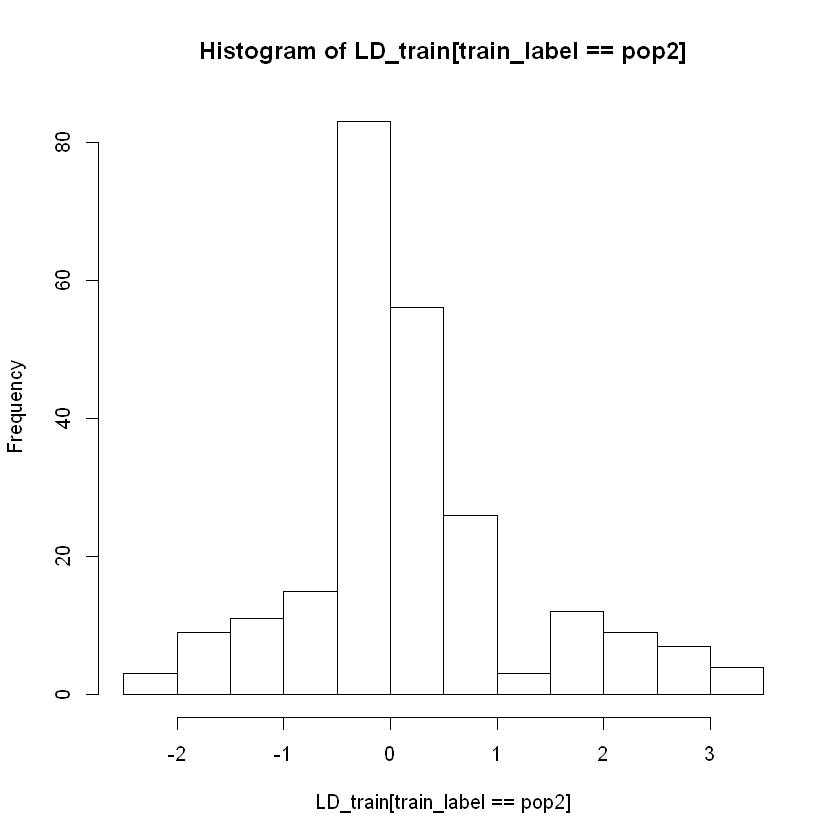

In [17]:
# LDA, AND EXTRACT THE ONLY LD COMPONENT
m_lda<-lda(train_feature, grouping=train_label, prior=c(0.5, 0.5))
LD_train<-train_feature%*%m_lda$scaling

[1] 50  1

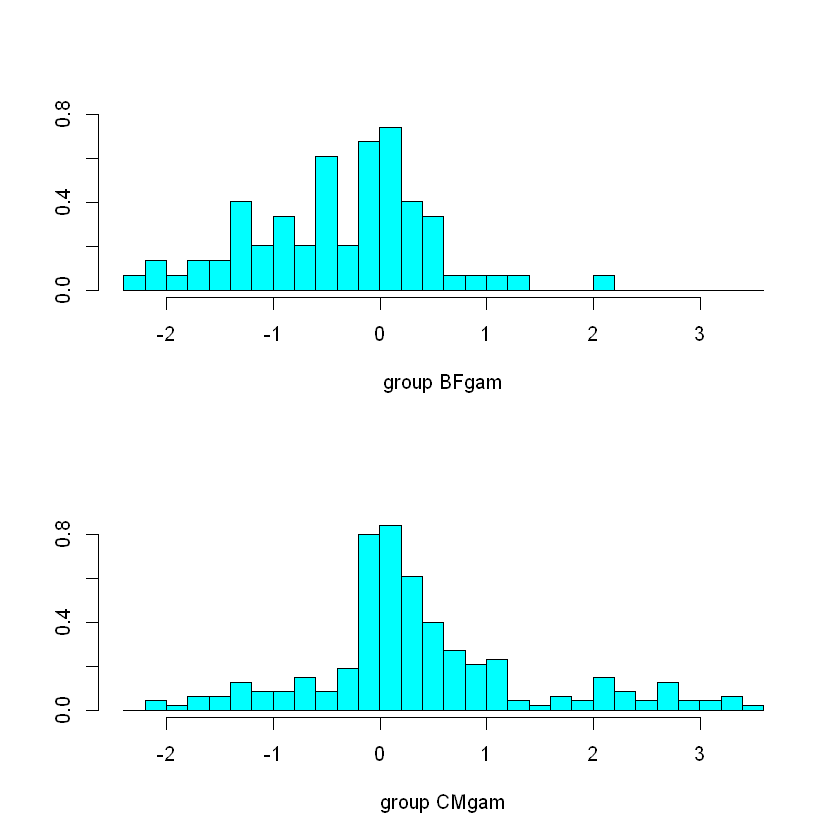

In [15]:
# OR SIMPLE PLOT IT OUT
plot(m_lda)

In [19]:
# NOW TURN TO THE TEST SET. FIRST NORMALISE IT VIA THE SAME PATTERSON FORMULA AND allele_freq
# THEN CREATE test_feature USING THE SAME PCA ROTATION
test_freq2<-matrix(train_freq, nc=ncol(test_genotype), nr=nrow(test_genotype), byrow=T)
normal_test_genotype<-(test_genotype-2*test_freq2)/sqrt(test_freq2*(1-test_freq2))
test_feature<-normal_test_genotype%*%e$rotation[,1:n]
dim(test_feature)
rm(train_freq); rm(test_freq2); invisible(gc());
# PREDICT THE CLASSES GIVEN THE TESTING FEATURES VIA THE EXISTING LDA MODEL. 
result_lda<-predict(m_lda, test_feature)$class
result_lda<-as.character(result_lda)
LD_test<-test_feature%*%m_lda$scaling
# ACCURACY
sum(result_lda==test_label)/length(test_label)

[1] 77 50

[1] 0.7272727

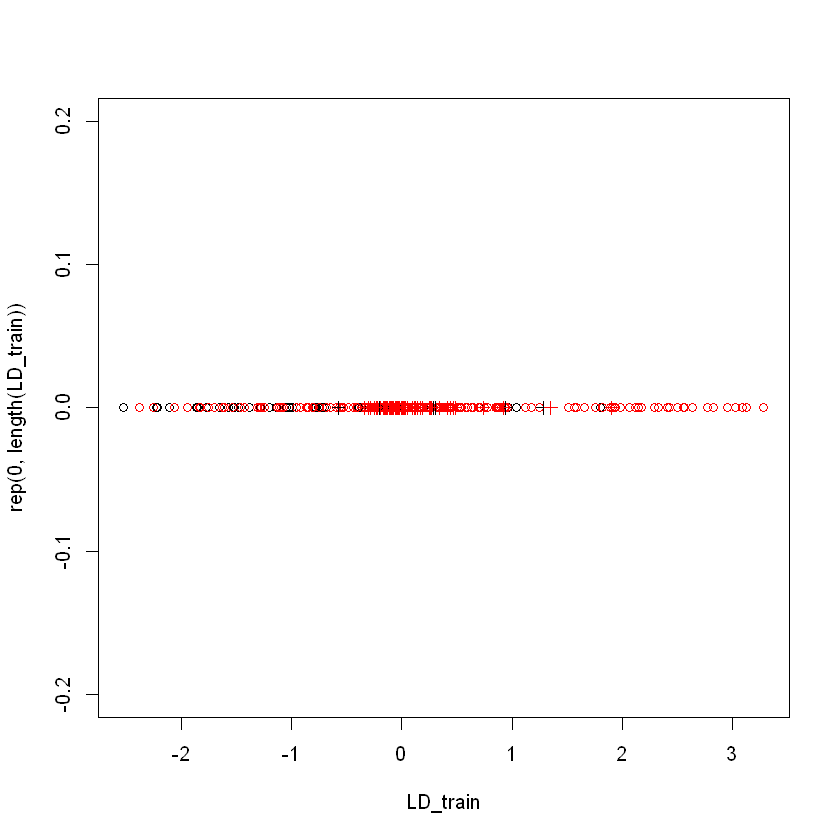

In [20]:
plot(LD_train, rep(0, length(LD_train)), col=train_col, ylim=c(-0.2, 0.2))
points(LD_test, rep(0, length(LD_test)), col=test_col, pch=3)

In [21]:
# HOW ABOUT USING LOGISTIC REGRESSION AS OUR CLASSIFIER? USE muiltinom() FROM PACKAGE nnet. 
# BUT WE NEED TO PUT train_label AND train_feature INTO A DATA FRAME. STUBBORN. 
# AND, NOT SURE IF I UNDERSTAND THE OUTPUTS FROM multinom(). 
train_df<-data.frame(train_label=train_label, train_feature=train_feature)
m_lr<-multinom(train_label~., data=train_df)

# weights:  52 (51 variable)
initial  value 216.261920 
iter  10 value 160.040778
iter  20 value 152.305255
iter  30 value 150.485107
iter  40 value 148.939593
iter  50 value 147.832421
iter  60 value 147.105045
iter  70 value 146.625598
final  value 146.621689 
converged


In [22]:
# PREDICT WITH OUT TEST SET. AGAIN I NEED TO CREATE A DATA FRAME. 
test_df<-data.frame(test_feature=test_feature)
# TO AVOID ERRORS I NEED TO SET THE COLUMN NAMES OF test_df TO MATCH THOSE OF train_df. VERY STUBBORN. 
names(test_df)<-names(train_df)[-1]
# PUT THE test_df TO TEST THE ALGORITHM
result_lr<-predict(m_lr, test_df, type='class')
result_lr<-as.character(result_lr)
# ACCURACY. SHOULD BE AROUND 90%
sum(result_lr==test_label)/length(test_label)

[1] 0.7662338

ERROR: Error in xy.coords(x, y, xlabel, ylabel, log): 'x' is a list, but does not have components 'x' and 'y'
